# Local Filtering and Edge Detection Exercises
This notebook proposes exercises on local filtering and edge detection.  We will work only on grayscale images.

#### Preparation

In [ ]:
import matplotlib.pyplot as plt

# plots directly in the notebook
%matplotlib inline 

# make figures larger
plt.rcParams["figure.figsize"] = (10,10)

# if you have a high-dpi monitor
#%config InlineBackend.figure_format = 'retina' 

import ipywidgets as widgets


#### Load and display a grayscale image

In [ ]:
import numpy as np
import skimage
import skimage.data
import skimage.io
im = skimage.data.camera()
im = skimage.color.rgb2gray(im)
# to read from a file: skimage.io.imread("myimage.png")
print(im.shape)
print(im.dtype)
plt.imshow(im,cmap="gray")

## Local filtering in 2D
Animation credits: https://github.com/vdumoulin/conv_arithmetic

With local filtering, the intensity value of one pixel in the output image (top cyan grid) is a function of a window of pixels (3x3 in the example) centered in the same location of the input image (bottom blue grid).  In other words, the value of the output pixel depends on a _neighborhood_ of that pixel in the input image.

![local filtering animation](https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/no_padding_no_strides.gif)

Note that in the example, the output image is _smaller_ than the input.  Otherwise, some output pixels would depend on values that are not in the input image.

We can also use _padding_ to artificially extend the input such that the output is the same size as the input, as shown below.

![local filtering animation with same-size padding](https://github.com/vdumoulin/conv_arithmetic/raw/master/gif/same_padding_no_strides.gif)

Which functions can we apply to the input neighborhood?
- One option is to compute a linear combination of the pixels' values; then, we define a convolution.
- Otherwise, we can apply nonlinear functions (such as median, maximum, minimum...).

## Linear filtering (convolutions)
We can convolve an input matrix (in our case, our input image) with a _kernel_, which is a matrix defining a weight for every element of the neighborhood.  The convolution can be considered a **moving weighted average** of the pixels.  The description below is adapted from [this document](https://github.com/vdumoulin/conv_arithmetic).  Another great explanation is [here](http://www.songho.ca/dsp/convolution/convolution2d_example.html).

A kernel of value
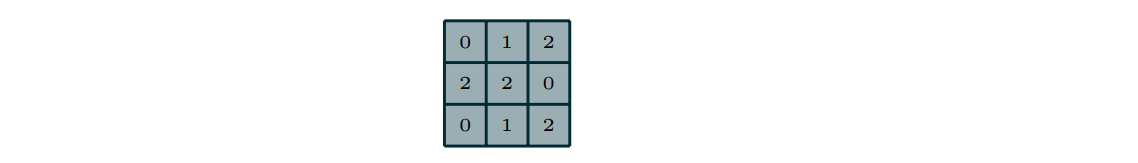
slides across the input matrix. At each location, the product between
each element of the kernel and the input element it overlaps is computed and
the results are summed up to obtain the output in the current location.

First, look at the result we get when we don't use any padding; then, the output matrix will be smaller than the input matrix; in general, if the input matrix has $i$ rows and the kernel has $k$ rows, the output will have $i-k+1$ rows; same applies to columns.

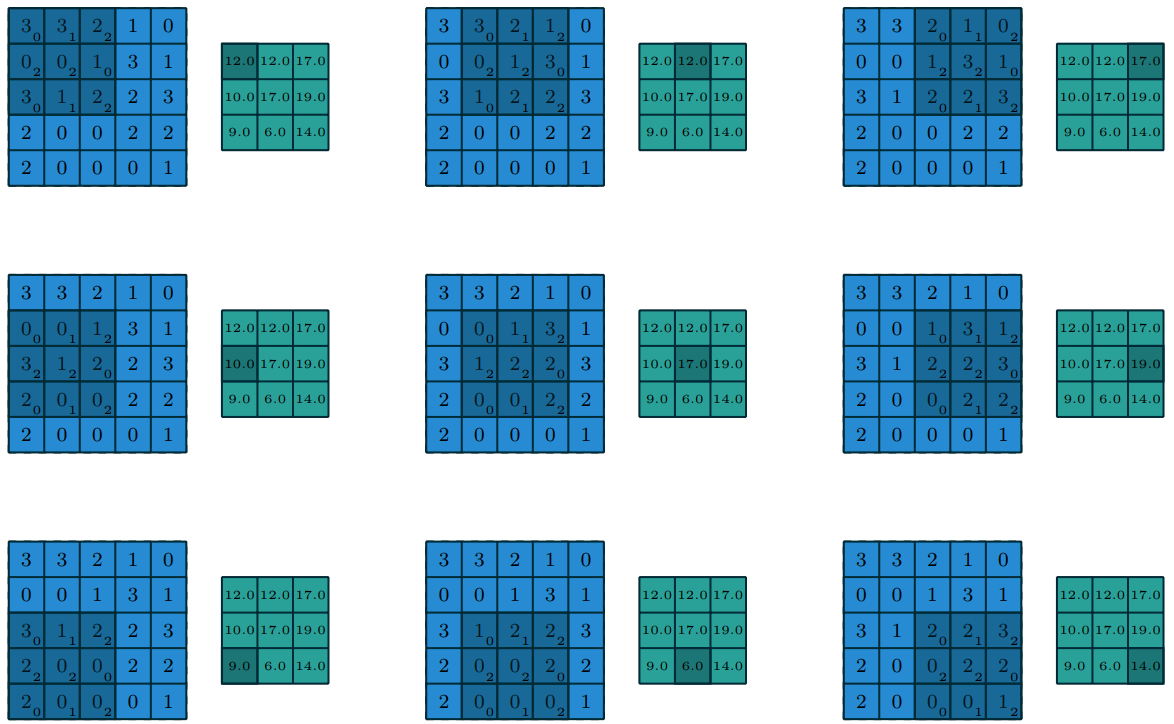

Often, we will use padding on the input image to get an output matrix that is the same size as the input.  Then, there are different options to handle the extra cells (see docs of the `mode` parameter of [`scipy.ndimage.convolve()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.convolve.html):
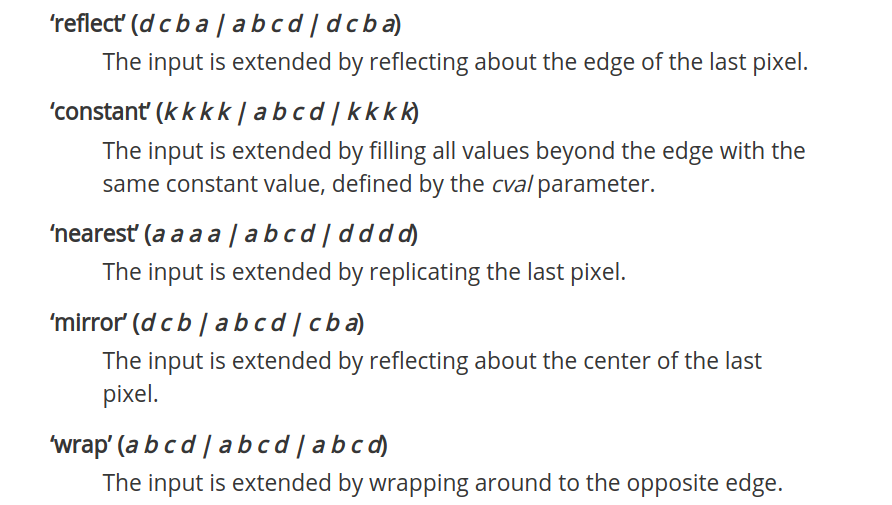

Let's now verify this in code.

In [ ]:
import scipy
a = np.array([   [3,3,2,1,0],
                 [0,0,1,3,1],
                 [3,1,2,2,3],
                 [2,0,0,2,2],
                 [2,0,0,0,1]])

k = np.array([   [0,1,2],
                 [2,2,0],
                 [0,1,2]])

scipy.ndimage.convolve(a, k[::-1,::-1], mode='constant', cval=0.0)

Note that the center 3x3 submatrix (i.e. the results that exclude the external padding) matches the one in the illustration.

Note also that we flipped the kernel both horizontally and vertically (`k[::-1,::-1]`) before feeding it to the `convolve` function.  This is because convolution will flip that kernel again before applying the operations above; it is a detail and should not worry you.

### Exercise
Predict the outputs of the following lines of code

In [ ]:
a = np.array([   [3,2,1],
                 [0,1,1],
                 [0,0,0],
                 [2,0,0]])

k = np.array([   [1,0,0],
                 [0,0,1],
                 [0,0,0]])

scipy.ndimage.convolve(a, k[::-1,::-1], mode='constant', cval=0.0)

Let us now discuss the effects of convolution on images.

### Smoothing filters: box filter (moving average)

A _box filter_ is a filter that just averages all values in the (square) neighborhood.

#### Exercise
Compute the output of the convolution of the matrix below with a 3x3 box filter
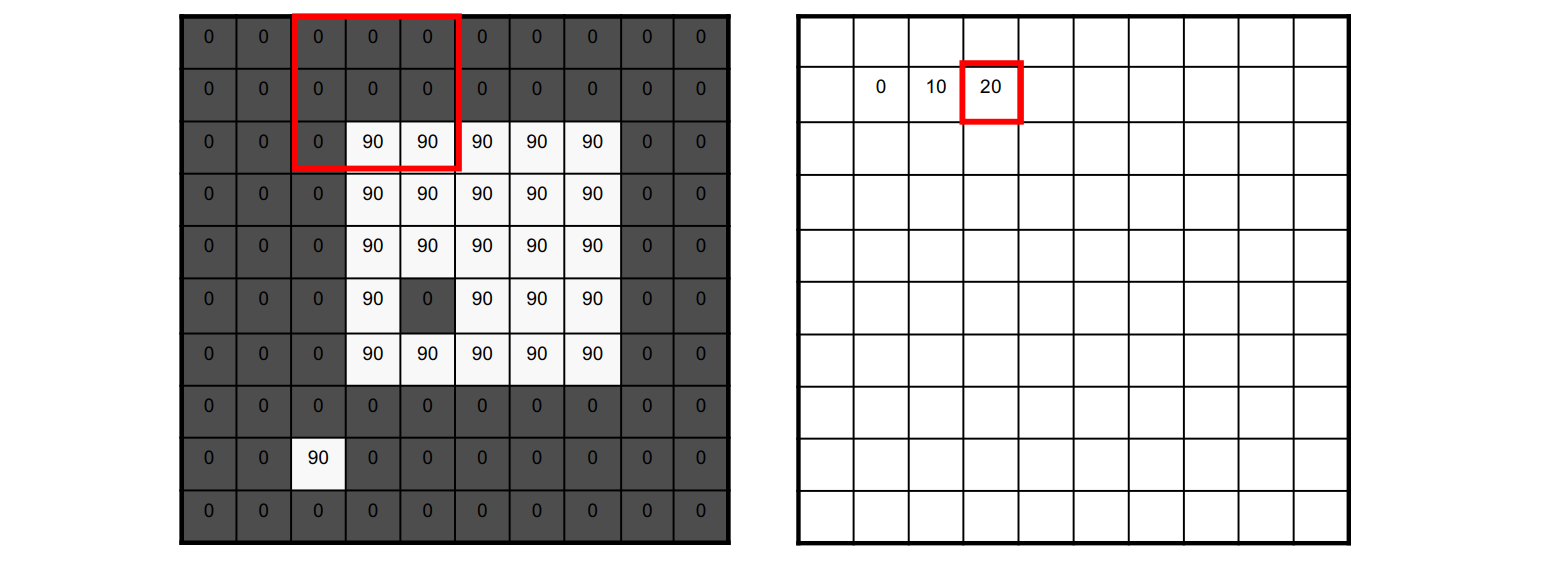

#### Solution
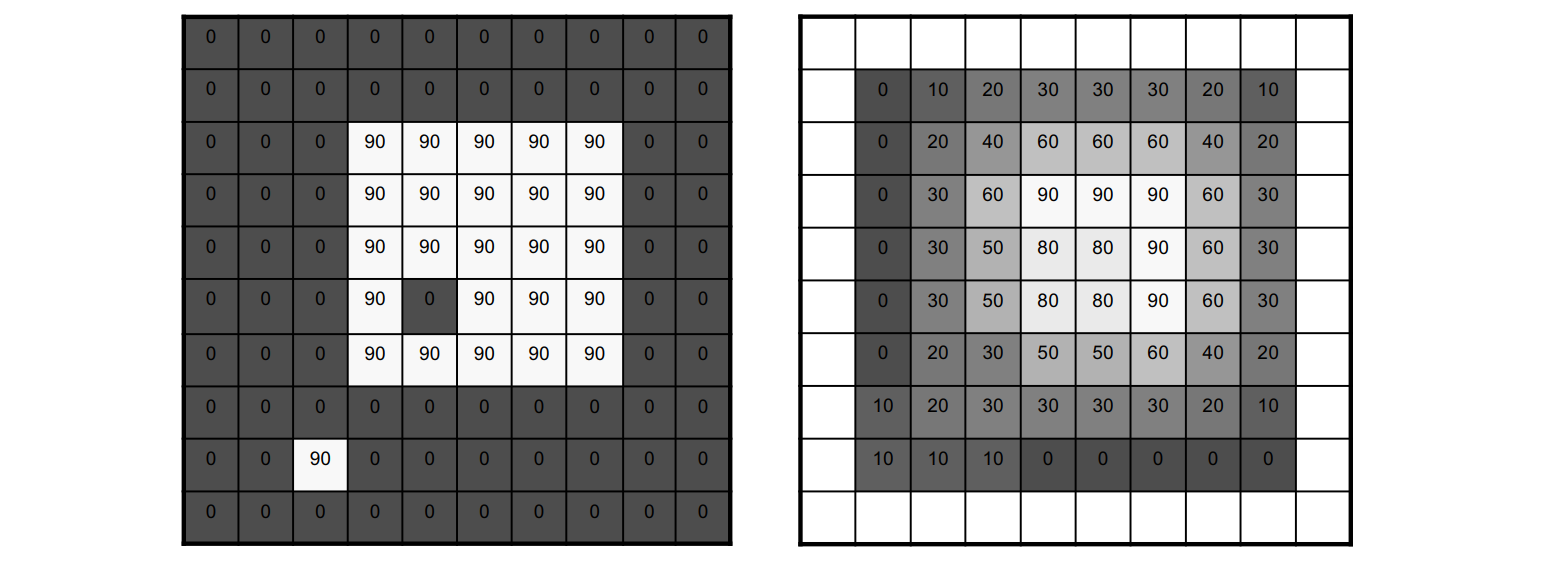

Let's now apply the filter to an image to see its effects

In [ ]:
im = skimage.img_as_float(skimage.data.camera())
@widgets.interact(sz = (1,21,2))
def f(sz):
    k = np.full((sz, sz), 1/(sz*sz))
    assert(np.isclose(np.sum(k),1.0))
    imf = scipy.ndimage.convolve(im, k[::-1,::-1], mode='constant', cval=0.0)
    plt.imshow(imf, cmap="gray", vmin=0, vmax=1)

### Smoothing filters: gaussian filter (weighted moving average)

Instead of considering all pixels in the neighborhood equally, it makes sense to implement a _weighted average_ and give more weight to the central pixels.  We can obtain that with a gaussian kernel.

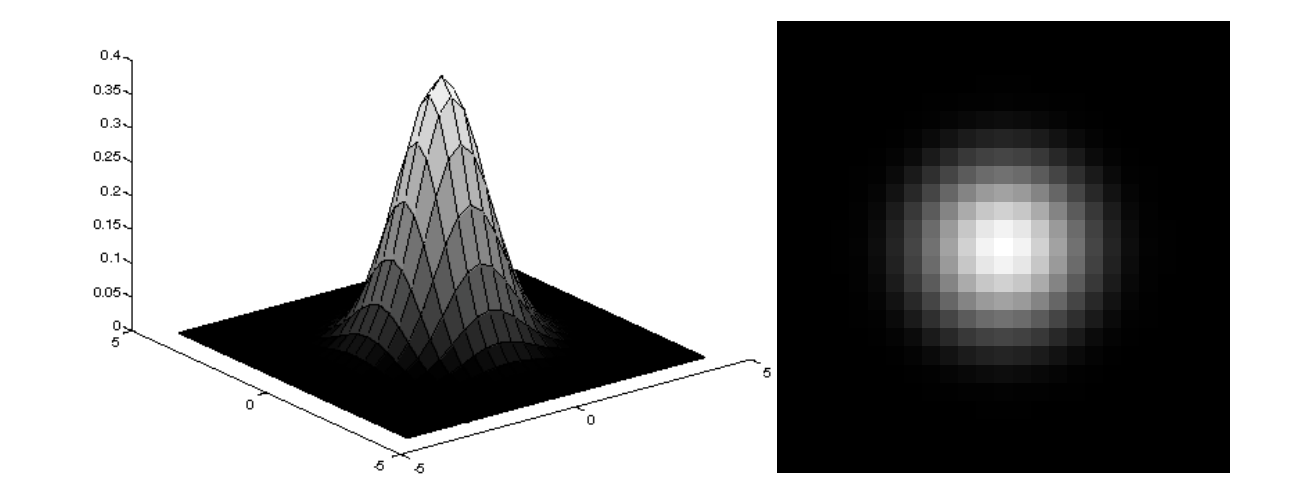

The variance of the gaussian ($\sigma$) determines how much we are smoothing:
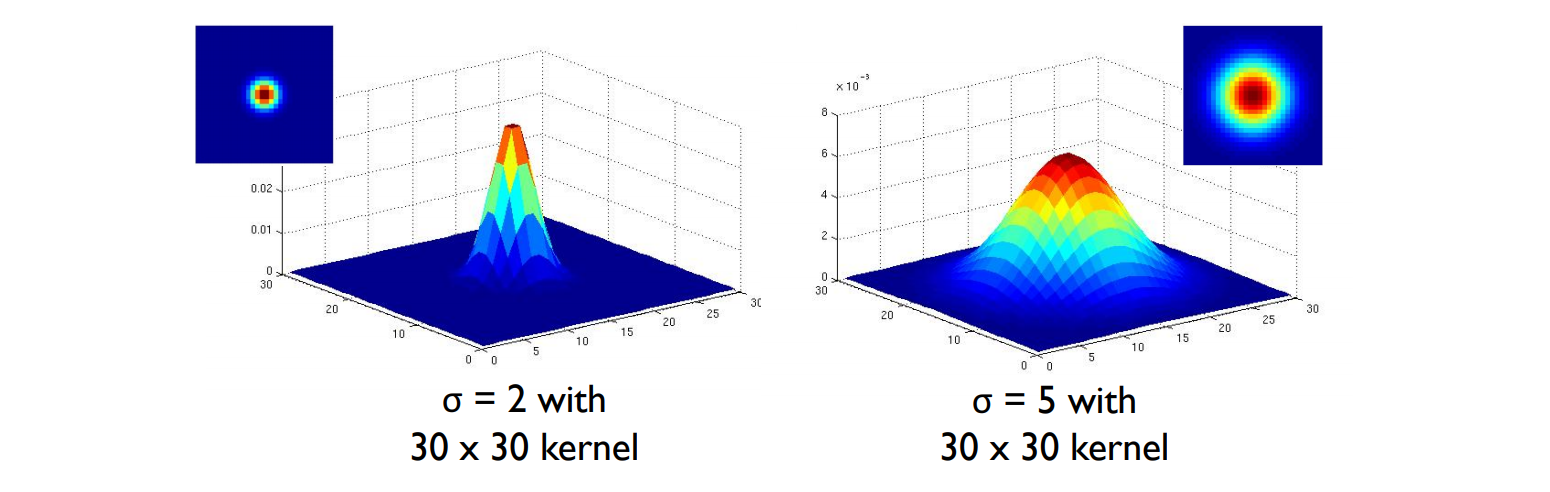.  The kernel is usually built to be big enough to not "cut away" any singnificant part of the function; normally, the kernel width and height is chosen to be about 3 times sigma.

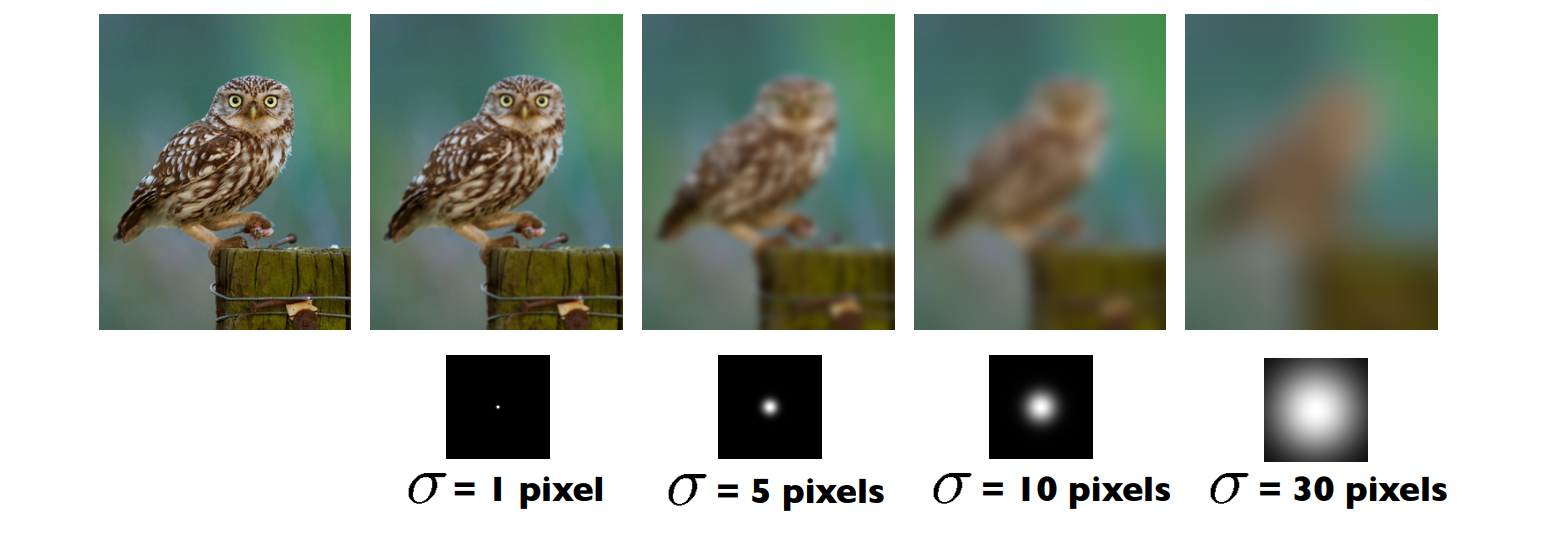

In [ ]:
im = skimage.img_as_float(skimage.data.camera())
@widgets.interact(sigma = (1,21,2))
def f(sigma):
    imf = skimage.filters.gaussian(im, sigma=sigma, mode='constant', cval=0.0)
    plt.imshow(imf, cmap="gray", vmin=0, vmax=1)

#### Exercise
What's the visual difference between the smoothing from a box filter and a smoothing from a gaussian filter?  Find out by showing side by side:
- the `camera` guy smoothed by a box filter with width 21
- the `camera` guy smoothed by a gaussian filter with a sigma that, to you, looks most similar

Look for differences close to high-contrast areas of the input.

Change the input image by adding a few isolated completely white pixels or rectangles, possibly over a very dark background.  Repeat the operation above.

### Edge-detection filters (image gradients)

#### Example in 1D
Let's replicate the example shown in the slides:
- build a 1D signal which is 0.0 for the first 100 samples, 1.0 for the next
- add some gaussian noise with `np.random.randn(...)` scaled to a given value
- plot the signal and the finite differences

We will build the signal as a 2D image with 1 row.

In [ ]:
@widgets.interact(amount=(0.0,1.0,0.01))
def f(amount):
    a = np.array([([0.0]*100) + ([1.0]*100)])
    an = a + np.random.randn(1,200) * amount
    kernel = np.array([[-1.0,1.0]])
    ad = scipy.ndimage.convolve(an,kernel[::-1,::-1])
    fig, axs = plt.subplots(nrows=2,ncols=1)
    axs[0].plot(an[0,:])
    axs[1].plot(ad[0,:]);

#### Exercise
Modify the code above in such a way that:
- you first smooth the signal by convolving with a box filter with a given length (i.e. run a moving average)
- then you compute the derivative of the result

#### Solution

In [ ]:
@widgets.interact(noise_amount=(0.0,1.0,0.01),
                  box_length=(1,11,2))
def f(noise_amount, box_length):
    #...
    pass

#### Exercise
What if the edge is "soft", instead of a step?  Will it be easier or harder to see as a peak in the derivative, for the same amount of noise?

Modify the code above in order to generate a smooth ramp instead of a step, and observe the differences

#### Solution

#### Computing gradients in 2D

In [ ]:
# Add some noise to the image
im_n = im + np.random.randn(im.shape[0], im.shape[1]) * 0.01

h_kernel = np.array([[-1,+1]])

im_gh = scipy.ndimage.convolve(im_n, h_kernel[::-1,::-1], mode='constant', cval=0.0)
plt.imshow(im_gh, vmin=-0.2, vmax=+0.2, cmap="bwr")
plt.colorbar()

Instead of using the simple finite differencing kernel, one often uses a 3x3 filter called the sobel operator.
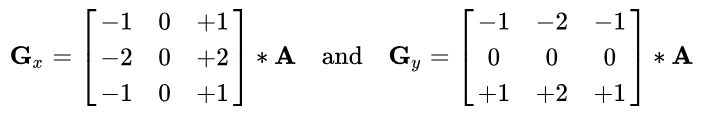

In [ ]:
sobel_h = np.array([[-1, 0 +1],[-2, 0 +2],[-1, 0 +1]])
sobel_v = sobel_h.T

In [ ]:
# Add some noise to the image
im_n = im + np.random.randn(im.shape[0], im.shape[1]) * 0.01

im_gh = scipy.ndimage.convolve(im_n, sobel_h[::-1,::-1], mode='constant', cval=0.0)
plt.imshow(im_gh, vmin=-0.5, vmax=+0.5, cmap="bwr")
plt.colorbar()

In order to detect edges at all orientation, we will compute (an approximation of) both the horizontal and vertical components of the image gradients with the sobel operator; then, we take the square root of the sum of their squares (pythagoras' theorem) to obtain the modulo of the gradient regardless on the direction.

In [ ]:
im_sobelh = scipy.ndimage.convolve(im, sobel_h[::-1,::-1], mode='constant', cval=0.0)
im_sobelv = scipy.ndimage.convolve(im, sobel_v[::-1,::-1], mode='constant', cval=0.0)
im_sobel = (im_sobelh ** 2 + im_sobelv ** 2) ** 0.5
fig, axs = plt.subplots(ncols=3)
axs[0].imshow(im_sobelh, vmin=-2, vmax=+2, cmap="bwr")
axs[1].imshow(im_sobelv, vmin=-2, vmax=+2, cmap="bwr")
axs[2].imshow(im_sobel,  vmin=0, vmax=+1, cmap="viridis")


#### Using the Canny edge detector

In [ ]:
import skimage.feature
im_edges = skimage.feature.canny(im)
plt.imshow(im_edges)

#### Exercise
Read the [documentation](http://scikit-image.org/docs/dev/auto_examples/edges/plot_canny.html) and explore the parameters of the canny function, especially the sigma and threshold values.  Build a function that allows you to tweak them and see results interactively.

Look for a good parameter set to find clean edges in the `skimage.data.coins()` image.

## Rank filters (nonlinear)
Also see [these examples](http://scikit-image.org/docs/dev/auto_examples/applications/plot_morphology.html#sphx-glr-auto-examples-applications-plot-morphology-py) on morphological filtering.
### Median
One option is to compute the _median_ of all values in the neighborhood.  The `skimage.filters.median` function implements this (and automatically pads the input image to make the output the same size as the input).  To define the size of the neighborhood (here called "structuring element") we can use the function `skimage.morphology.square()`.

In [ ]:
import skimage.filters
import skimage.morphology
selem = skimage.morphology.square(9)
print("this is our structuring element (neighborhood)")
print(selem)
imf = skimage.filters.median(im, selem)
plt.imshow(np.hstack((im,imf)), cmap="gray")

#### Exercise
Modify the input image to change all pixels in a given line to white.  What happens to the line after median filtering with a 3x3 structuring element?  What if the line was black?  What if the line was 2 pixels tall? 

In [ ]:
# ...

### Maximum (also known as _dilation_) or minimum (also known as _erosion_)

We can take the _maximum_ or _minimum_ of all pixels in the neighborhood.
Taking the maximum will grow (_dilate_) bright objects; taking the minimum will shrink them and grow dark objects instead.

### Non-square structuring elements

When operating with rank filters, we can consider also non-square structuring elements.  E.g. a circular structuring element can be created with [`skimage.morphology.disk(radius)`](http://scikit-image.org/docs/dev/api/skimage.morphology.html#disk).

In [ ]:
strel = skimage.morphology.disk(4)
print(strel)

In [ ]:
# let's make a gray image with some white and some black dots
im = np.full((100,100), 0.5)
for _ in range(10):
    r = np.random.randint(100)
    c = np.random.randint(100)
    im[r,c] = np.random.rand()
    
im[50,:] = 0
im[:,70] = 1

im1 = skimage.morphology.dilation(im, strel)
im2 = skimage.morphology.erosion(im, strel)
fig, axs = plt.subplots(ncols = 3)
axs[0].imshow(im,cmap="gray",vmin=0,vmax=1)
axs[0].set(title="original")
axs[1].imshow(im1,cmap="gray",vmin=0,vmax=1)
axs[1].set(title="dilated")
axs[2].imshow(im2,cmap="gray",vmin=0,vmax=1)
axs[2].set(title="eroded")

#### Exercise
Load the rice image from the url below. How could you make the grains disappear while keeping the background?  Try to predict the correct radius of a circular structuring element to achieve this goal, then try; do you need to use erosion or dilation?

In [ ]:
im = skimage.io.imread("https://carmbrustdotcom.files.wordpress.com/2016/10/rice.png")

### Using erosion and dilation on binary images to regularize noisy masks (binary opening and binary closing)

Consider a binary image (mask).  If you apply an dilation followed by an erosion, both using the same structuring element, the effect is to make the mask _more regular_.  In particular, the effect is to close holes in the mask that are smaller than the structuring element (try to understand why!).  The operation is in fact called _closing_.  However, this also tends to join close objects together in the mask.

Applying the operations in the opposite order (erosion followed by dilation) is known as _opening_.  The effect is to separate objects joined by narrow bridges.

Explore the effects below, on the _coins_ image we already used previously.

In [ ]:
im = skimage.img_as_float(skimage.color.rgb2gray(skimage.data.coins()))

@widgets.interact(
    threshold = (0,1,0.05),
    strel_radius = (0,8))
def f(threshold, strel_radius):
    mask = im > threshold
    strel = skimage.morphology.disk(radius=strel_radius)
    mask_dil = skimage.morphology.dilation(mask, strel)
    mask_dil_ero = skimage.morphology.erosion(mask_dil, strel)
    
    fig, axs = plt.subplots(ncols=3, figsize=(15,10))
    axs[0].imshow(mask,cmap="gray",vmin=0,vmax=1)
    axs[0].set(title="original")
    axs[1].imshow(mask_dil,cmap="gray",vmin=0,vmax=1)
    axs[1].set(title="dilated")
    axs[2].imshow(mask_dil_ero,cmap="gray",vmin=0,vmax=1)
    axs[2].set(title="dilated then eroded (closing)")

#### Exercise
Modify the code above to run an opening instead of a closing (e.g. erosion followed by dilation).